# PID Control with a Luenberger Observer


David Brown, Lindsay Farrell, Niijor May, and Ashley Young

CBE 30338, Chemical Process Control

-----

## Data Organization

The Luenberger observer is designed using a collection of step data from the TCLab device.

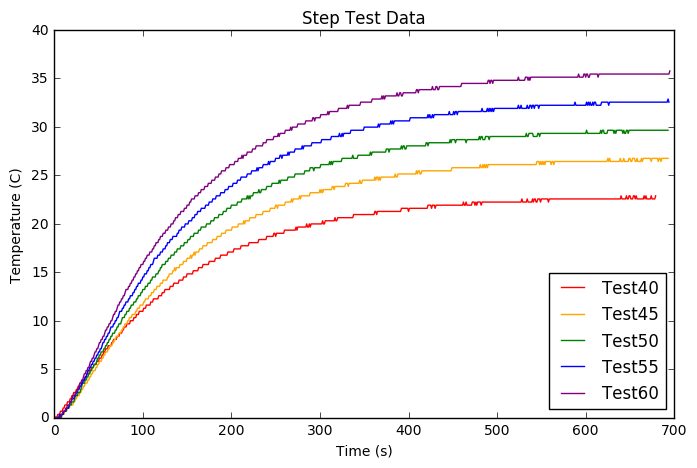

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

save_dpi=400

exps =  {'Test40' : {'u' : 0.4, 'color' : 'red'},
         'Test45' : {'u' : 0.45,'color' : 'orange'},
         'Test50' : {'u' : 0.5, 'color' : 'green'},
         'Test55' : {'u' : 0.55,'color' : 'blue'},
         'Test60' : {'u' : 0.6, 'color' : 'purple'}}

data = pd.DataFrame({'Test40' : pd.read_csv('04_Step_Data/Step40')['T1'],
                     'Test45' : pd.read_csv('04_Step_Data/Step45')['T1'],
                     'Test50' : pd.read_csv('04_Step_Data/Step50')['T1'],
                     'Test55' : pd.read_csv('04_Step_Data/Step55')['T1'],
                     'Test60' : pd.read_csv('04_Step_Data/Step60')['T1']})

D = data.keys()

plt.figure(figsize=[8,5])
for d in D:
    T_amb = data[d][1]
    data[d] = data[d][1:] - T_amb
    data[d].plot(color=exps[d]['color'])
    
plt.title('Step Test Data')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
plt.axis([0,700,0,40])
plt.legend(loc=4)

plt.savefig('05_Figures/00_step_data_plot',dpi=save_dpi)

## Initial Estimates from First Order Model

The gross heat transfer coefficient is estimated by analyzing the process at steady state. With an estimate for the heat transfer coefficient, the heat capacity can be estimated by fitting the first order model to the step data.

Heat Transfer Coefficient, Ua = 0.068447
Heat Capacity, Cp = 7.000000


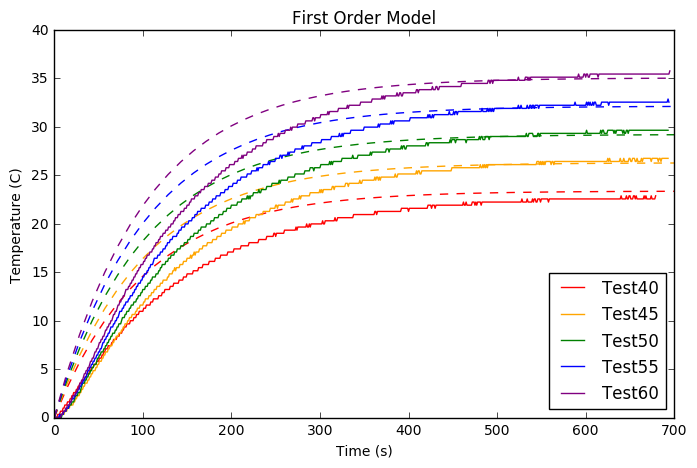

In [2]:
P1 = 4
time = np.linspace(0,700)
Cp = 7

Ua = sum(P1*exps[d]['u']/data[d][600:650].mean() for d in D)/len(D)

plt.figure(figsize=[8,5])
for d in D:  
    T_est = (P1/Ua)*exps[d]['u'] * (1 - np.exp((-Ua*time)/Cp))
    plt.plot(time,T_est,'--', color=exps[d]['color'])
    data[d].plot(color = exps[d]['color'])
    

plt.title('First Order Model')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
plt.axis([0,700,0,40])
plt.legend(loc=4)

plt.savefig('05_Figures/01_first_order_model',dpi=save_dpi)

print('Heat Transfer Coefficient, Ua = %f' %Ua)
print('Heat Capacity, Cp = %f' %Cp)

## Fitting Data to Second Order Model

By fitting the step test data with the coefficients $K$, $\tau$ and $\zeta$, the step data can be used to determine the model parameters.

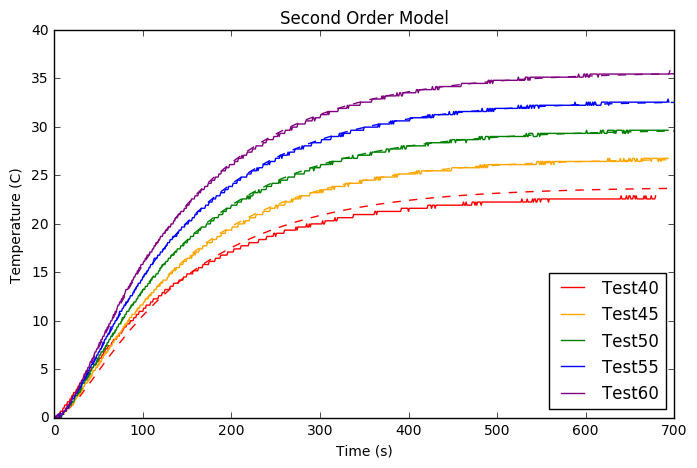

In [3]:
K = 59.5
tau = 53
zeta = 1.45

tau_1 = tau/(zeta - np.sqrt(zeta**2 - 1))
tau_2 = tau/(zeta + np.sqrt(zeta**2 - 1))

plt.figure(figsize=[8,5])

for d in D:
    T_est = K*exps[d]['u']*(1 - ((tau_1*np.exp(-time/tau_1) - tau_2*np.exp(-time/tau_2))/(tau_1 - tau_2)))
    plt.plot(time,T_est,'--',color=exps[d]['color'])
    data[d].plot(color = exps[d]['color'])
    
plt.title('Second Order Model')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
plt.axis([0,700,0,40])
plt.legend(loc=4)

plt.savefig('05_Figures/02_second_order_model',dpi=save_dpi)

## Determining Model Parameters

This section also contains some of the algorithm for determining the constraints for the observer gain.

In [4]:
x3 = K/(tau**2)*(Cp/P1)
x1 = x3 - 2*zeta/tau
x2 = -1*(x1 + 1/(x3*(tau**2)))

A = np.matrix([[x1,x2],[x3,-x3]])
#print(A)

import sympy as sym

test = sym.Matrix(A)

l1, l2 , lam = sym.symbols('l_1 l_2 \lambda')

test[0,0] = test[0,0] - lam
test[0,1] = test[0,1] - l1
test[1,1] = test[1,1] - l2 - lam

sol = sym.collect(test.det(),lam)
#print(sol)


a = sol.coeff(lam, 2)
b = sol.coeff(lam, 1)
c = sol.coeff(lam, 0)

eigenval1 = (-b + (b**2 - 4*a*c)**0.5)/(2*a)
eigenval2 = (-b - (b**2 - 4*a*c)**0.5)/(2*a)

L = [(l1,0.2),(l2,0.1)]

print(eigenval1.subs(L))
print(eigenval2.subs(L))

-0.0773584905660377 + 0.0595835195269363*I
-0.0773584905660377 - 0.0595835195269363*I


## Applying Observer to Sample Data

This section applys the observer to a set of data.

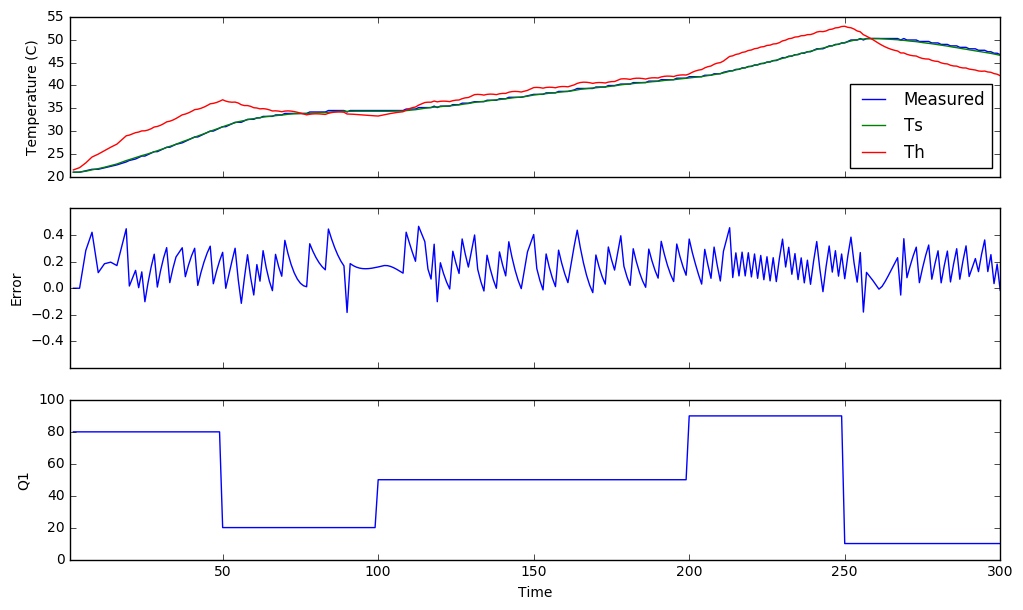

In [5]:
data = pd.read_csv('04_Step_Data/obs_test1')

data['dt'] = data['Time'].diff()

A = np.matrix([[-0.01764863,0.00804479],[ 0.03706835,-0.03706835]])
B = np.matrix([[(4/7)*1e-2],[0]])

L = np.matrix([[1],[0.2]])

data.loc[0,'Ts'] = data['T1'][0]
data.loc[0,'Th'] = data['T1'][0]

results = pd.DataFrame()

for i in range(1,len(data)):
    
    data.loc[i,'Error'] = data.loc[i,'T1'] - data.loc[i-1,'Ts']
    
    x = np.matrix([[data.loc[i-1,'Th']] , [data.loc[i-1,'Ts']]])
    
    dx = np.matmul(A,x) + B*data.loc[i-1,'Q1'] +  L*data.loc[i,'Error']

    x = x + dx*data.loc[i,'dt']
    
    data.loc[i,'Th'] = x[0,0]
    data.loc[i,'Ts'] = x[1,0]

results = data.loc[1:,['T1','Ts','Th','Time','Error','Q1']]

fig, ax = plt.subplots(nrows = 3,figsize=[12,7],sharex=True)

ax[0].set_xlim([1,300])

ax[0].plot(results['Time'],results['T1'], label ='Measured')
ax[0].plot(results['Time'],results['Ts'], label ='Ts')
ax[0].plot(results['Time'],results['Th'], label ='Th')
ax[0].set_ylim([20,55])
ax[0].legend(loc=4)
ax[0].set_ylabel('Temperature (C)')

ax[1].plot(results['Time'],results['Error'])
ax[1].set_ylim([-0.6,0.6])
ax[1].set_ylabel('Error')

ax[2].plot(results['Time'],results['Q1'])
ax[2].set_ylim([0,100])
ax[2].set_ylabel('Q1')
ax[2].set_xlabel('Time')

plt.savefig('05_Figures/03_observer_test',dpi=save_dpi)